In [1]:
import numpy as np
from sklearn.covariance import GraphicalLassoCV
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from sklearn.utils import resample #Bootstrapping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
#plt.rcParams["figure.figsize"] = (15,8)

##  Gene Expression Cancer RNA-Seq Data Set 

### $\bullet$ For the data: $\href{https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq}{\texttt{GECRNA-SEQ (click here)}}$

### $\color{pink}{\textbf{UCI Machine Learning Repository}}$

In [370]:
X = pd.read_csv('gene_data.csv').iloc[:, 1:] #Genes
y = pd.read_csv('gene_labels.csv').iloc[:, 1:] #labels

In [371]:
X

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [372]:
set(y['Class'])

{'BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'}

$\bullet$ `BRCA`: Breast Invasive Carcinoma ($\texttt{Breast Cancer}$)

$\bullet$ `COAD`: Colon Adenocarcinoma ($\texttt{Colon Cancer}$)

$\bullet$ `KIRC`: Kidney Renal Clear Cell Carcinoma ($\texttt{Kidney Cancer}$)

$\bullet$ `LUAD`: Lung Adenocarcinoma ($\texttt{Lung Cancer}$)

$\bullet$ `PRAD`: Prostate Adenocarcinoma ($\texttt{Prostate Cancer}$)

### Data Set Information:

Samples (instances) are stored row-wise. Variables (attributes) of each sample are $\textbf{RNA-Seq gene expression levels}$ measured by illumina HiSeq platform.

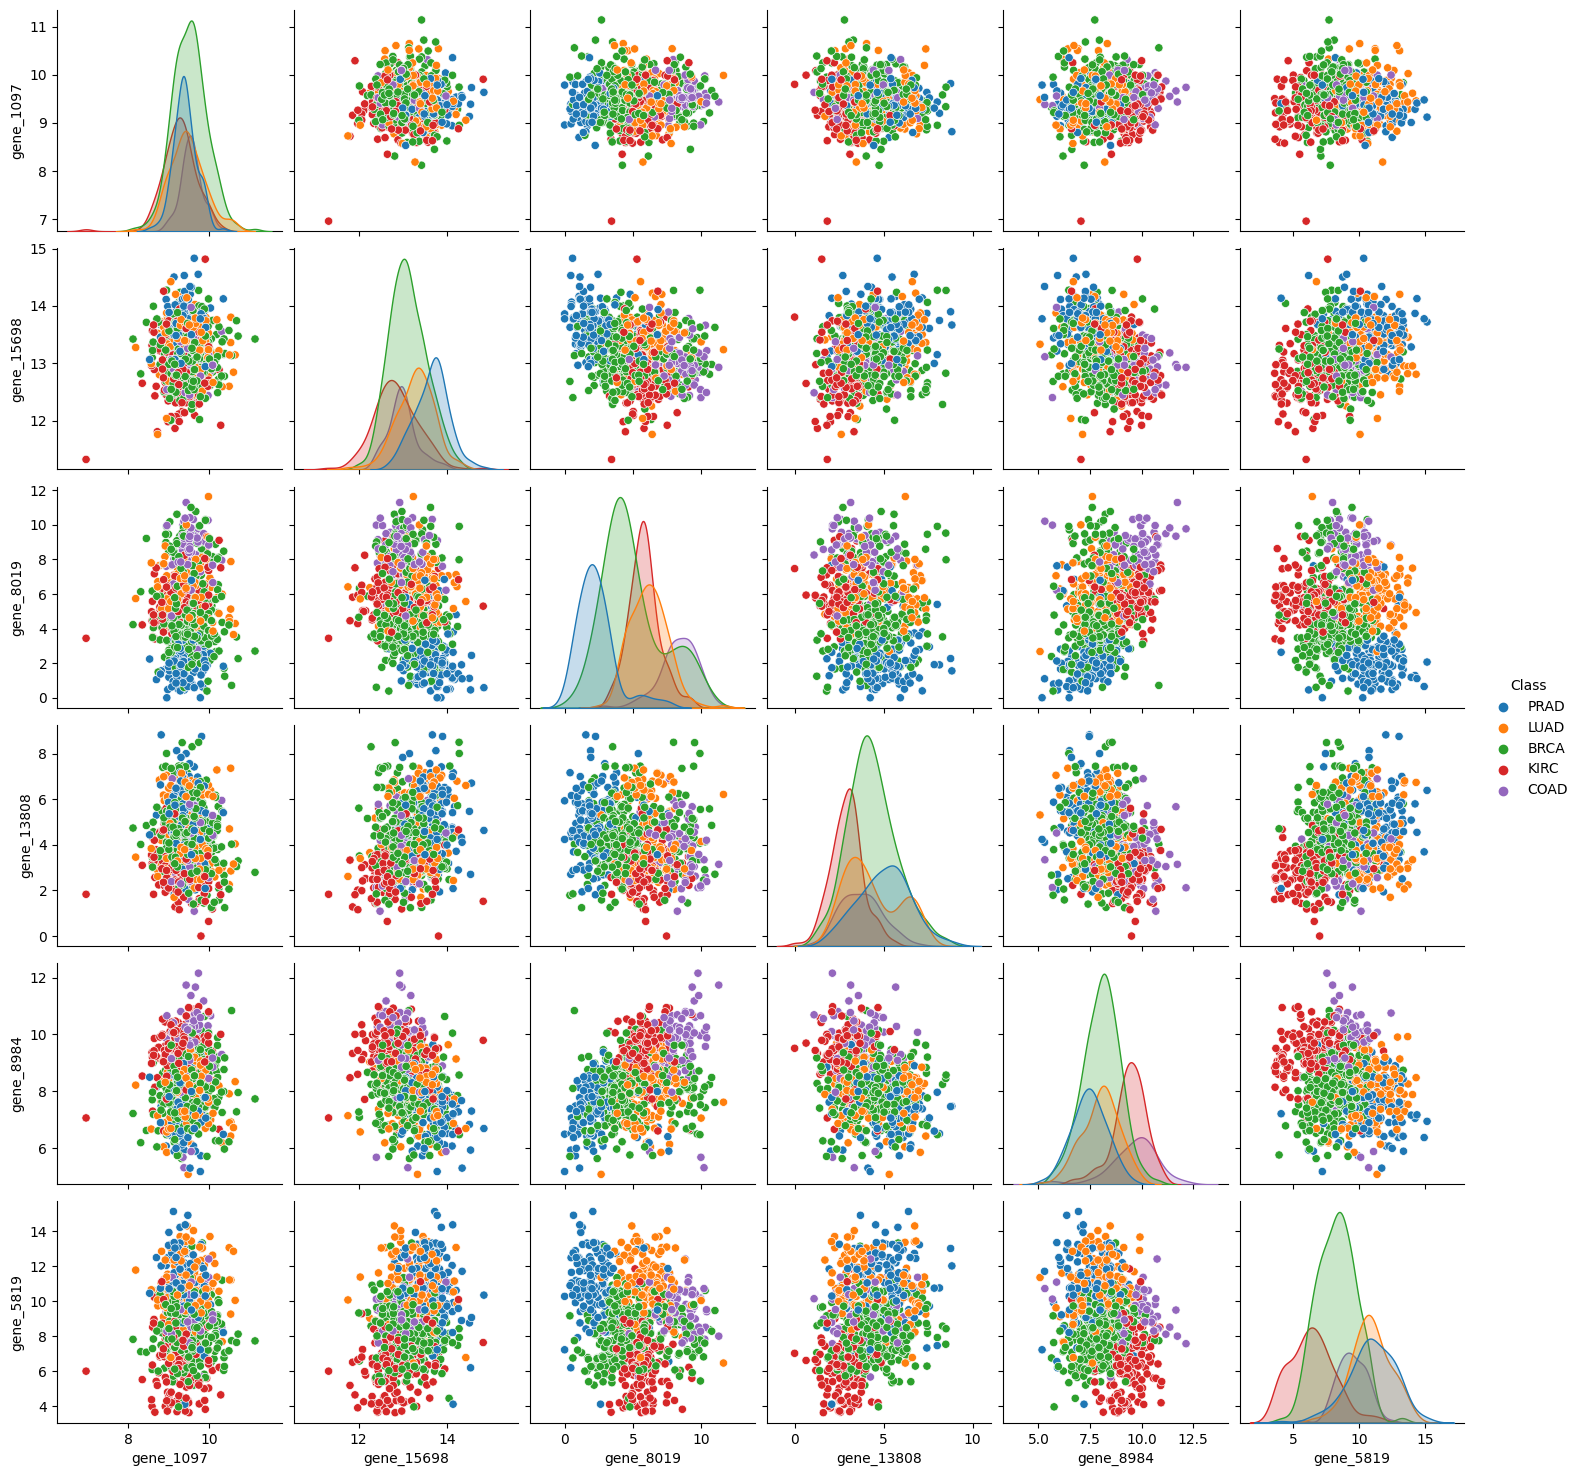

In [373]:
random.seed(765)
sns.pairplot(pd.concat([X,y],axis=1),
             hue="Class",
             vars=random.sample(X.columns.tolist(), 6))
             
plt.show()

In [374]:
y['Class'] = y['Class'].map(dict(zip(set(y['Class']),
                            range(len(set(y['Class']))))))
y

,Class
0,3
1,4
2,3
3,3
4,0
...,...
796,0
797,4
798,1
799,3


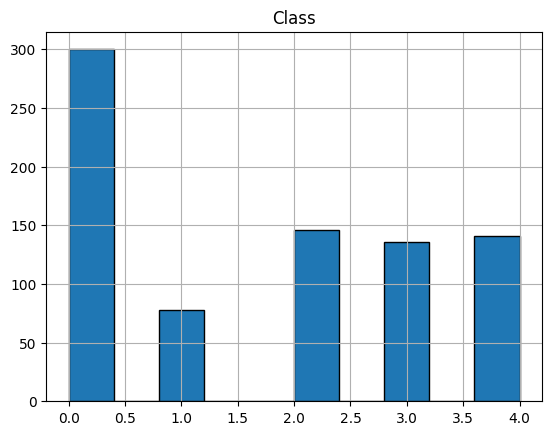

In [375]:
y.hist(edgecolor='black')
plt.show()

In [25]:
scaler = StandardScaler()
scaler.fit(X)
X_ = pd.DataFrame(scaler.transform(X),
                  columns=X.columns)

## The $\texttt{Graphical Lasso}$ algorithm has a time complexity of $O(p^3)$

$\bullet$ `Feature Selection`

$\bullet$ `Dimensionality Reduction`

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [12]:
from sklearn.manifold import TSNE

components = 3

tsne = TSNE(n_components=components,
            random_state=5666)

tsneComponents = tsne.fit_transform(X_)


tsneDf = pd.DataFrame(data = tsneComponents,
                      columns=[f'comp_{i}' for i in range(1,components+1)])

tsneDf

,comp_1,comp_2,comp_3
0,-4.152413,0.678622,7.779712
1,-2.266597,3.704805,-5.308658
2,-0.776046,2.948305,15.039043
3,-0.381685,2.265692,13.506628
4,-0.401649,-8.973346,1.780151
...,...,...,...
796,0.654388,-7.982281,2.318673
797,-5.885597,5.888442,-1.291026
798,-7.675886,1.403439,-6.720069
799,-4.955318,4.409647,10.828624


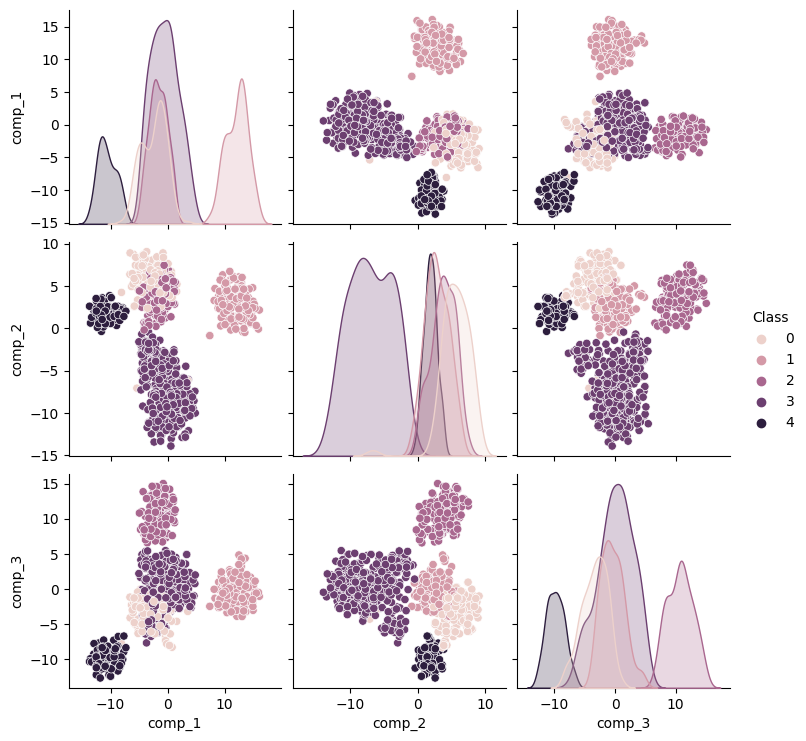

In [13]:
sns.pairplot(pd.concat([tsneDf,y], axis=1),
             hue="Class", vars=tsneDf.columns)
             
plt.show()

In [118]:
from sklearn.linear_model import Lasso

In [122]:
lasso_reg = Lasso()
lasso_reg.fit(X,y)

Lasso()

In [135]:
list(filter(lambda x: x!=0., lasso_reg.coef_))

[0.04485830060630499,
 0.01046189914767575,
 0.016970189681260822,
 0.027594381450720046,
 -0.047053355303030946,
 0.046214486412512655,
 0.07698797385416545,
 0.03682864889281376,
 0.030848175581946143]

In [233]:
%%time

from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=[9e-6, 1e-5],
                   cv=10,
                   max_iter=10000)

lasso_cv.fit(X, np.ravel(y))

# The optimal alpha
print('Optimal alpha: \n', lasso_cv.alpha_)

# The coefficients
print('Coefficients: \n', lasso_cv.coef_)

Optimal alpha: 
 9e-06
Coefficients: 
 [ 0.          0.02185141  0.11479955 ...  0.         -0.
  0.        ]
CPU times: user 11min 3s, sys: 10.7 s, total: 11min 13s
Wall time: 10min 37s


In [234]:
#  #Features  with !=0 coeff
len(list(filter(lambda x: x!=0., lasso_cv.coef_))) #3305

2240

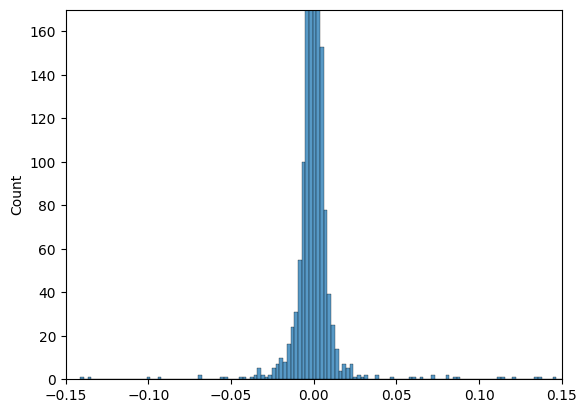

In [238]:
sns.histplot(lasso_cv.coef_, bins=150)
plt.ylim([0,170])
plt.xlim([-0.15, 0.15])
plt.show()

In [240]:
lasso_features = X.columns[np.where(lasso_cv.coef_!=0)[0]]

lasso_X = X[lasso_features]
lasso_X

,gene_1,gene_2,gene_3,gene_4,gene_6,gene_18,gene_19,gene_20,gene_21,gene_26,...,gene_20345,gene_20360,gene_20373,gene_20379,gene_20389,gene_20466,gene_20484,gene_20490,gene_20496,gene_20504
0,2.017209,3.265527,5.478487,10.431999,7.175175,0.591871,5.619994,1.334282,0.000000,7.215116,...,4.106767,7.536092,0.000000,0.591871,7.360224,4.377061,2.717803,0.000000,2.736583,2.602077
1,0.592732,1.588421,7.586157,9.623011,6.816049,0.000000,11.055208,3.562621,0.000000,9.949812,...,7.783522,5.117043,0.000000,0.587845,2.814879,2.530820,4.516185,4.008227,3.134993,0.811142
2,3.511759,4.327199,6.881787,9.870730,6.972130,1.683023,8.210248,4.195285,3.660427,6.096650,...,5.283733,7.746353,0.000000,0.452595,4.306933,6.172313,6.535353,2.337254,3.677147,5.014445
3,3.663618,4.507649,6.659068,10.196184,7.843375,1.267356,8.306317,3.573556,0.000000,3.913761,...,1.637239,9.783866,0.000000,3.696094,7.728424,6.318335,4.466457,0.434882,3.609755,6.233192
4,2.655741,2.821547,6.539454,9.738265,6.566967,0.889707,10.149150,2.967630,0.000000,1.942120,...,3.335812,10.827287,0.649386,4.879083,6.171291,6.775999,0.889707,2.045093,3.655810,4.586531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1.865642,2.718197,7.350099,10.006003,6.764792,0.496922,7.763611,3.205502,1.955573,0.000000,...,2.922160,10.582010,0.000000,4.125114,6.114061,7.520336,0.496922,3.070784,4.792324,1.611739
797,3.942955,4.453807,6.346597,10.056868,7.320331,0.000000,9.650467,3.844888,0.000000,9.169589,...,2.539233,8.614375,0.000000,0.618051,7.789997,6.547101,0.618051,0.000000,3.537246,3.173351
798,3.249582,3.707492,8.185901,9.504082,7.536589,1.002595,9.326032,4.705480,5.179822,1.325099,...,2.704872,8.557896,3.812221,4.496859,6.559773,6.825366,1.588469,2.326135,5.386570,4.092394
799,2.590339,2.787976,7.318624,9.987136,9.213464,0.000000,7.987867,3.991236,0.000000,3.450934,...,5.798175,8.059463,0.581881,1.992986,5.810998,4.035615,5.745713,0.000000,4.706630,5.861179


# $\texttt{Graphical Lasso}$

In [243]:
%%time
# Apply GraphicalLassoCV
glasso = GraphicalLassoCV(alphas=[10, 50, 300, 600],
                          cv=10,
                          mode='cd',
                          max_iter=10000,
                          n_jobs=-1) #Parallel Backend

# Fit the model to your data
glasso.fit(lasso_X)

invalid value encountered in subtract


CPU times: user 5min 24s, sys: 40.1 s, total: 6min 4s
Wall time: 11min 27s


GraphicalLassoCV(alphas=[10, 50, 300, 600], cv=10, max_iter=10000, n_jobs=-1)

$\texttt{LARS}$ stands for `Least Angle Regression`. It's a regression algorithm for high-dimensional data, developed by `Bradley Efron`, `Trevor Hastie`, `Iain Johnstone`, and `Robert Tibshirani`.

LARS is similar to forward stepwise regression. At each step, it finds the predictor most correlated with the response. When there are multiple predictors having equal correlation, instead of continuing along the same predictor, it proceeds in a direction equiangular between the predictors.

In [244]:
glasso.alpha_

10

In [279]:
Theta = glasso.precision_ #Sigma inverse
Sigma = glasso.covariance_

In [280]:
Sigma.shape

(2240, 2240)

In [308]:
zero_elem = len(np.where(np.around(Theta, decimals=6).reshape(-1)==0)[0])
non_zero_elem = len(np.where(np.around(Theta, decimals=6).reshape(-1)!=0)[0])

print(f'#zero elements on the Theta matrix: {zero_elem}')
print(f'#Non-zero elements on the Theta matrix: {non_zero_elem}')

#zero elements on the Theta matrix: 5013934
#Non-zero elements on the Theta matrix: 3666


In [287]:
# Theta @ Sigma = Id
Theta @ Sigma

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

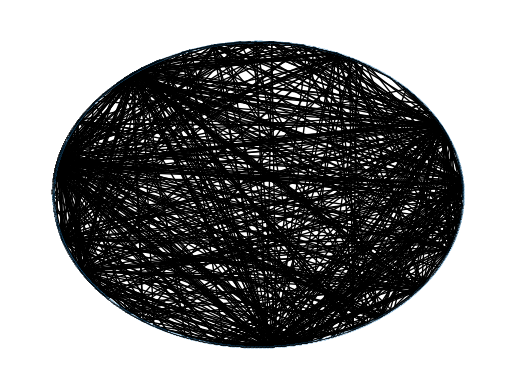

In [368]:
import networkx as nx

G = nx.Graph()

# Add nodes
n = Theta.shape[0]
G.add_nodes_from(range(n))

# Add edges for non-zero entries
for i in range(n):
    for j in range(i+1, n):  # we only look at upper triangular part as the matrix is symmetric
        if Theta[i, j] != 0:
            G.add_edge(i, j)

# Draw the graph with small nodes and labels
pos = nx.shell_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=0.01)

# edges
nx.draw_networkx_edges(G, pos)

# labels
nx.draw_networkx_labels(G, pos, font_size=0.01)

plt.axis('off')
plt.show()

In [337]:
%%time

#Let's make it sparser

glasso2 = GraphicalLassoCV(alphas=[20, 23],
                          cv=10,
                          mode='cd',
                          max_iter=10000,
                          n_jobs=-1)

# Fit the model to your data
glasso2.fit(lasso_X)

invalid value encountered in subtract


CPU times: user 1min 12s, sys: 11.1 s, total: 1min 23s
Wall time: 3min 15s


GraphicalLassoCV(alphas=[20, 23], cv=10, max_iter=10000, n_jobs=-1)

In [338]:
glasso2.alpha_

20

In [339]:
Theta2 = glasso2.precision_ #Sigma inverse
Sigma2 = glasso2.covariance_

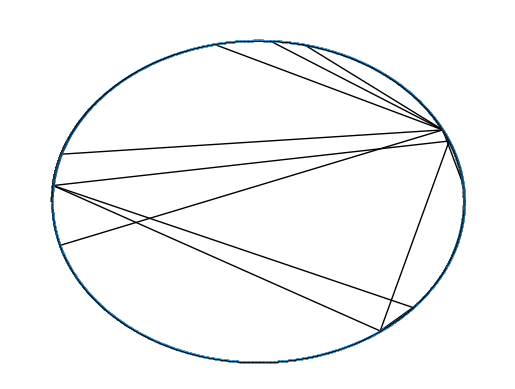

In [367]:
G = nx.Graph()

# Add nodes
n = Theta2.shape[0]
G.add_nodes_from(range(n))

# Add edges for non-zero entries
for i in range(n):
    for j in range(i+1, n):  # we only look at upper triangular part as the matrix is symmetric
        if Theta2[i, j] != 0:
            G.add_edge(i, j)

# Draw the graph with small nodes and labels
pos = nx.shell_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=0.2)

# edges
nx.draw_networkx_edges(G, pos)

# labels
nx.draw_networkx_labels(G, pos, font_size=0.3)

plt.axis('off')
plt.show()

In [361]:
%%time

#Let's make it sparser

glasso3 = GraphicalLassoCV(alphas=[13, 15],
                          cv=10,
                          mode='cd',
                          max_iter=10000,
                          n_jobs=-1)

# Fit the model to your data
glasso3.fit(lasso_X)

invalid value encountered in subtract


CPU times: user 2min 11s, sys: 16.1 s, total: 2min 27s
Wall time: 4min 55s


GraphicalLassoCV(alphas=[13, 15], cv=10, max_iter=10000, n_jobs=-1)

In [362]:
Theta3 = glasso3.precision_ #Sigma inverse
Sigma3 = glasso3.covariance_

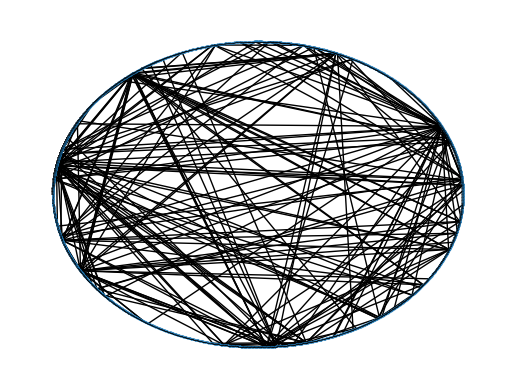

In [365]:
G = nx.Graph()

# Add nodes
n = Theta3.shape[0]
G.add_nodes_from(range(n))

# Add edges for non-zero entries
for i in range(n):
    for j in range(i+1, n):  # we only look at upper triangular part as the matrix is symmetric
        if Theta3[i, j] != 0:
            G.add_edge(i, j)

# Draw the graph with small nodes and labels
pos = nx.shell_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=0.2)

# edges
nx.draw_networkx_edges(G, pos)

# labels
nx.draw_networkx_labels(G, pos, font_size=0.3)

plt.axis('off')
plt.show()